In [53]:
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os

# Define root directory
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import CONFIGPATH

# Loading ChEMBL preprocessed data
print("Loading ChEMBL preprocessed data...")
ChEMBL = pd.read_csv(os.path.join(root, "..", "config", "chembl_processed", "activities_preprocessed.csv"), low_memory=False)
print(f"Original size: {len(ChEMBL)}")
print("Filtering out nan values...")
ChEMBL = ChEMBL[ChEMBL['value'].isna() == False].reset_index(drop=True)
print(f"Size after filtering nan values: {len(ChEMBL)}")

# Load directionality
direction = pd.read_csv(os.path.join(CONFIGPATH, "manual_curation", "activity_std_units_curated_manual_curation.csv"))
direction = direction[direction['manual_curation'].isna() == False]
direction = {(i,j): int(k) for i,j,k in zip(direction['activity_type'], direction['unit'], direction['manual_curation'])}

# List of pathogens to process
pathogens = ["Mycobacterium tuberculosis"]

Loading ChEMBL preprocessed data...
Original size: 24267312
Filtering out nan values...
Size after filtering nan values: 20911360


In [31]:
# For each pathogen
for pathogen in pathogens:
    
    # Get assays info
    pathogen_code = str(pathogen.split()[0][0] + pathogen.split()[1]).lower()
    print(f"\n\nFiltering data from pathogen: {pathogen_code}...")
    ChEMBL_ = ChEMBL[ChEMBL['target_organism'].str.contains(pathogen, case=False, na=False) | 
                    ChEMBL['assay_organism'].str.contains(pathogen, case=False, na=False)].reset_index(drop=True)
    
    # Load assays
    print(f"Number of activities for {pathogen}: {len(ChEMBL_)}")
    ASSAYS_INFO = pd.read_csv(os.path.join(root, "..", "output", pathogen_code, 'assays.csv'))
    ASSAYS_INFO = ASSAYS_INFO[['assay_id', 'activity_type', 'unit', 'activities', 'cpds']].copy()
    print(f"Original number of assays: {len(ASSAYS_INFO)}")



Filtering data from pathogen: mtuberculosis...
Number of activities for Mycobacterium tuberculosis: 706206
Original number of assays: 11346


In [50]:
# For each assay
for assay_id, activity_type, unit in tqdm(ASSAYS_INFO[['assay_id', 'activity_type', 'unit']].values):

    # If unit is nan
    if pd.isna(unit):
        assay_data = ChEMBL_[(ChEMBL_['assay_chembl_id'] == assay_id) & (ChEMBL_['activity_type'] == activity_type) & 
                                    (ChEMBL_['unit'].isna() == True) & (ChEMBL_['canonical_smiles'].isna() == False)]
    else:
        assay_data = ChEMBL_[(ChEMBL_['assay_chembl_id'] == assay_id) & (ChEMBL_['activity_type'] == activity_type) & 
                                    (ChEMBL_['unit'] == unit) & (ChEMBL_['canonical_smiles'].isna() == False)]
        
    # Filter assay data
    assay_data = assay_data[['assay_chembl_id', 'target_chembl_id', 'compound_chembl_id', 'canonical_smiles', 'MW', 'pchembl', 
                             'activity_comment', 'standard_text', 'value', 'unit', 'activity_type', 'relation', 'pchembl_calculated']]
        
    # If activity type - unit not in direction dict:
    if (activity_type, unit) not in direction:
        print(f"Activity type - unit not in direction dict: {activity_type} - {unit}. Consider manual curation.")
    else:
        # Get direction
        dir_ = direction[(activity_type, unit)]
        
    break

  0%|          | 0/11346 [00:00<?, ?it/s]


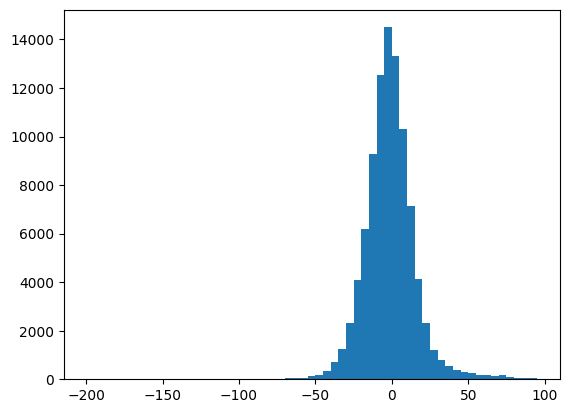

In [57]:
plt.hist(assay_data['value'].tolist(), bins=[i for i in range(-200, 100, 5)])
plt.show()

In [58]:
assay_data

,assay_chembl_id,target_chembl_id,compound_chembl_id,canonical_smiles,MW,pchembl,activity_comment,standard_text,value,unit,activity_type,relation,pchembl_calculated
95225,CHEMBL4649948,CHEMBL612545,CHEMBL3487824,Cn1cc(CCN2CCOC(CNc3cccnn3)C2)cn1,302.382,NaN,0,0,-33.180,%,PERCENTEFFECT,=,NaN
95226,CHEMBL4649948,CHEMBL612545,CHEMBL3487744,CC(=O)N(C)C(c1cccc(F)c1)c1ccccn1,258.296,NaN,0,0,-3.704,%,PERCENTEFFECT,=,NaN
95227,CHEMBL4649948,CHEMBL612545,CHEMBL3487768,CCc1noc(CN2CCN(c3nccs3)CC2)n1,279.369,NaN,0,0,-28.810,%,PERCENTEFFECT,=,NaN
95228,CHEMBL4649948,CHEMBL612545,CHEMBL3492745,Cc1nc(C2CCCN2C(=O)CCCn2cncn2)no1,290.327,NaN,0,0,-15.040,%,PERCENTEFFECT,=,NaN
95229,CHEMBL4649948,CHEMBL612545,CHEMBL3487973,OCCN1CCN(Cc2coc(-c3ccccc3)n2)CC1,287.363,NaN,0,0,-9.754,%,PERCENTEFFECT,=,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
688157,CHEMBL4649948,CHEMBL612545,CHEMBL1499416,Nc1ccn(Cc2ccccc2)n1,173.219,NaN,0,0,19.050,%,PERCENTEFFECT,=,NaN
688158,CHEMBL4649948,CHEMBL612545,CHEMBL4562294,Cn1cc(C(=O)NCc2cccc(F)c2)ccc1=O,260.268,NaN,0,0,-7.690,%,PERCENTEFFECT,=,NaN
688159,CHEMBL4649948,CHEMBL612545,CHEMBL4563458,CN(C)C(=O)NCCNc1nc(-c2ccccc2)ns1,291.380,NaN,0,0,-12.060,%,PERCENTEFFECT,=,NaN
688160,CHEMBL4649948,CHEMBL612545,CHEMBL4588858,CNCc1nc(C(F)(F)F)cs1,196.197,NaN,0,0,4.224,%,PERCENTEFFECT,=,NaN
